# Hard Drive Failure Prediction

## Step 1: Download and Prepare the Backblaze Drive Stats Dataset
Dataset Source:
URL: https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q1_2025.zip


In [1]:
import os
import zipfile
import requests
import pandas as pd
from glob import glob

# Create a directory for the dataset
os.makedirs('backblaze_data', exist_ok=True)

# Download the ZIP file
url = "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q1_2025.zip"
local_zip_path = "backblaze_data/data_Q1_2025.zip"

if not os.path.exists(local_zip_path):
    print("Downloading the dataset...")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_zip_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    print("Download complete.")

# Unzip the dataset
extract_dir = "backblaze_data/unzipped"
if not os.path.exists(extract_dir):
    print("Extracting dataset...")
    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Extraction complete.")

# Read a sample of the data (e.g., first 10 days)
csv_files = sorted(glob(os.path.join(extract_dir, "**", "*.csv"), recursive=True))[:10]


## Step 2: Load and transforming data

In [2]:
# To load and concatenate all:
# # Load and concatenate the daily files
# dataframes = []
# for file in csv_files:
#     try:
#         df = pd.read_csv(file)
#         dataframes.append(df)
#     except Exception as e:
#         print(f"Failed to read {file}: {e}")

# # Check number of CSVs found
# print(f"Found {len(csv_files)} CSV files.")

# dataframes = []
# for file in csv_files:
#     print(f"Reading: {file}")
#     try:
#         df = pd.read_csv(file)
#         if not df.empty:
#             dataframes.append(df)
#             print(f"  Loaded {len(df)} rows.")
#         else:
#             print("  Skipped empty file.")
#     except Exception as e:
#         print(f"  Failed to read {file}: {e}")

# # Try concatenation only if we have valid dataframes
# if dataframes:
#     df_all = pd.concat(dataframes, ignore_index=True)
#     print("Combined dataset shape:", df_all.shape)
#     print("Columns available:", df_all.columns.tolist())
# else:
#     print("No valid dataframes were loaded.")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load and combine the first 3 CSV files
dfs = []
for file in csv_files[:3]:
    print(f"Loading: {file}")
    df = pd.read_csv(file)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
print("Total combined shape:", df_all.shape)

# Drop non-informative metadata columns
drop_cols = [
    'date', 'serial_number', 'model', 'datacenter', 'cluster_id',
    'vault_id', 'pod_id', 'pod_slot_num', 'is_legacy_format'
]
df_all.drop(columns=drop_cols, inplace=True, errors='ignore')

# Drop columns with more than 50% missing values
threshold = len(df_all) * 0.5
df_all = df_all.dropna(thresh=threshold, axis=1)

# Fill remaining missing values with median
df_all.fillna(df_all.median(numeric_only=True), inplace=True)

# Separate features and label
X = df_all.drop(columns=['failure'], errors='ignore')
y = df_all['failure']

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data (70% train, 15% val, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Samples => Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print("Failures in train/val/test:", sum(y_train), sum(y_val), sum(y_test))


Loading: backblaze_data/unzipped/data_Q1_2025/2025-01-01.csv
Loading: backblaze_data/unzipped/data_Q1_2025/2025-01-02.csv
Loading: backblaze_data/unzipped/data_Q1_2025/2025-01-03.csv
Total combined shape: (914647, 197)
Samples => Train: 640252, Val: 137197, Test: 137198
Failures in train/val/test: 24 5 5


## Step 3: Model training (TensorFlow + statistical methods)

In [3]:
# A: TensorFlow Model Code
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

# --------------------------
# Step 1: Clean up labels
# --------------------------
y_train = y_train.values.astype(int)
y_val = y_val.values.astype(int)
y_test = y_test.values.astype(int)

# --------------------------
# Step 2: Compute class weights
# --------------------------
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

# --------------------------
# Step 3: Define the model
# --------------------------
model = Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),  # Avoids warning
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

# --------------------------
# Step 4: Early stopping
# --------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --------------------------
# Step 5: Train the model
# --------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=512,
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=2
)


2025-07-08 12:31:04.110678: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Class weights: {0: 0.5000187433226913, 1: 13338.583333333334}
Epoch 1/50
1251/1251 - 3s - 2ms/step - accuracy: 0.9571 - auc: 0.4759 - loss: 1.2568 - val_accuracy: 5.8310e-05 - val_auc: 0.7742 - val_loss: 0.8831
Epoch 2/50
1251/1251 - 2s - 1ms/step - accuracy: 0.4734 - auc: 0.5167 - loss: 0.7320 - val_accuracy: 0.9605 - val_auc: 0.8271 - val_loss: 0.5544
Epoch 3/50
1251/1251 - 3s - 2ms/step - accuracy: 0.7961 - auc: 0.6224 - loss: 0.7252 - val_accuracy: 0.9058 - val_auc: 0.7819 - val_loss: 0.4982
Epoch 4/50
1251/1251 - 2s - 1ms/step - accuracy: 0.6764 - auc: 0.6639 - loss: 0.6683 - val_accuracy: 0.9998 - val_auc: 0.7638 - val_loss: 0.3554
Epoch 5/50
1251/1251 - 1s - 1ms/step - accuracy: 0.7222 - auc: 0.7096 - loss: 0.6306 - val_accuracy: 0.0331 - val_auc: 0.7247 - val_loss: 0.9569
Epoch 6/50
1251/1251 - 1s - 1ms/step - accuracy: 0.6566 - auc: 0.7447 - loss: 0.6042 - val_accuracy: 0.8617 - val_auc: 0.7421 - val_loss: 0.3495
Epoch 7/50
1251/1251 - 3s - 2ms/step - accuracy: 0.7586 - auc: 0

In [5]:
# B) Logistic Regression Model (Scikit-Learn)
## Interrupted Due to Long Runtime -> Limit Features (e.g., top 30 most correlated), 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Select top 30 features using ANOVA F-score
selector = SelectKBest(score_func=f_classif, k=30)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

# Train logistic regression with class weighting
logreg = LogisticRegression(max_iter=500, class_weight='balanced')
logreg.fit(X_train_reduced, y_train)

# Predict and evaluate
y_pred_lr = logreg.predict(X_test_reduced)
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
print("AUC:", roc_auc_score(y_test, logreg.predict_proba(X_test_reduced)[:, 1]))

# ## if not worked -> Use a faster solver (e.g., solver='saga') and penalty='l2' 
# logreg = LogisticRegression(
#     max_iter=300, 
#     solver='saga',
#     penalty='l2',
#     class_weight='balanced'
# )
# logreg.fit(X_train, y_train)


Logistic Regression Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    137193
           1       0.00      0.60      0.00         5

    accuracy                           0.90    137198
   macro avg       0.50      0.75      0.47    137198
weighted avg       1.00      0.90      0.95    137198

AUC: 0.8762662818073809


## Step 4: Evaluation & Visualization

In [6]:
### Evaluate TensorFlow Model on Test Set
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

#### Predict on test set
y_pred_tf_prob = model.predict(X_test).ravel()
y_pred_tf = (y_pred_tf_prob > 0.5).astype(int)

#### Evaluation
print("TensorFlow Model Report:")
print(classification_report(y_test, y_pred_tf))
print("AUC:", roc_auc_score(y_test, y_pred_tf_prob))


4288/4288 ━━━━━━━━━━━━━━━━━━━━ 2s 537us/step
TensorFlow Model Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    137193
           1       0.00      0.20      0.00         5

    accuracy                           0.92    137198
   macro avg       0.50      0.56      0.48    137198
weighted avg       1.00      0.92      0.96    137198

AUC: 0.6934770724453871


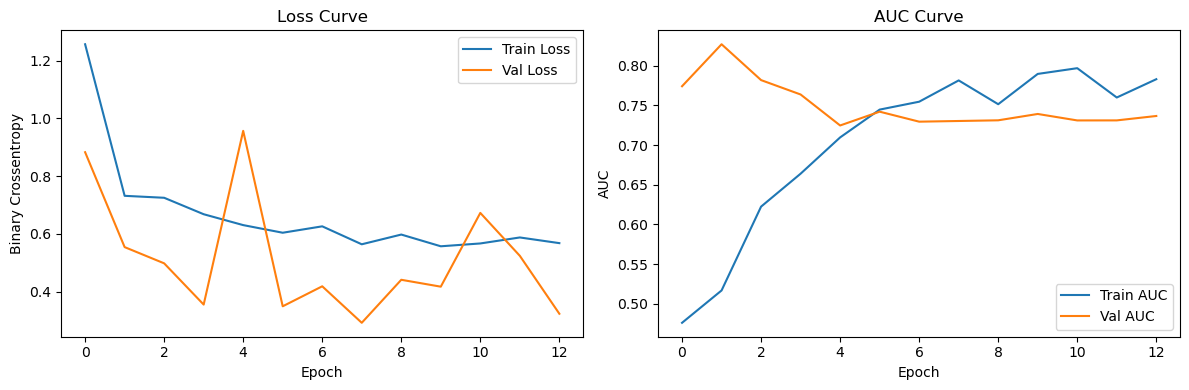

In [7]:
### Plot Training Curves (Loss & AUC)

import matplotlib.pyplot as plt

#### Plot loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()

#### Plot AUC
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC Curve')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
plt.show()


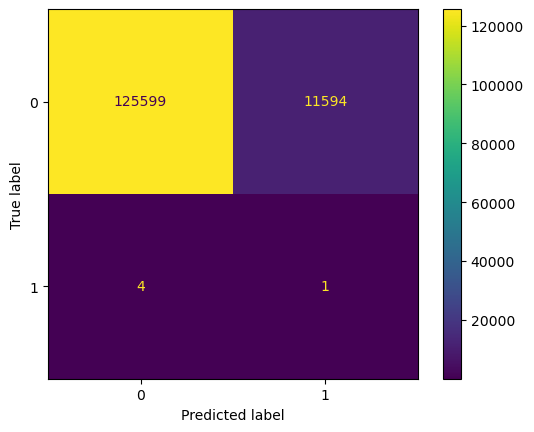

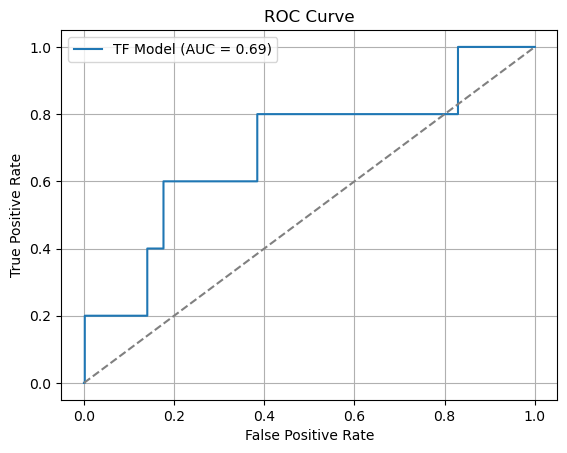

In [8]:
### Confusion Matrix & ROC Curve

from sklearn.metrics import roc_curve, ConfusionMatrixDisplay

#### Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tf)

#### ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_tf_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"TF Model (AUC = {roc_auc_score(y_test, y_pred_tf_prob):.2f})")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


## Conclusion
In this study, we developed and evaluated predictive models for hard drive failure detection using the publicly available Backblaze Drive Stats dataset for Q1 2025. We processed and analyzed daily SMART (Self-Monitoring, Analysis, and Reporting Technology) attribute snapshots, along with metadata such as capacity_bytes and failure labels. After cleaning and normalizing the data, we trained two types of models: a deep learning model using TensorFlow and a classical machine learning model using logistic regression with feature selection. Given the extreme class imbalance in the dataset—where disk failures represented a fraction of one percent—we applied class weighting and feature reduction techniques to improve model sensitivity. The TensorFlow model showed progressive learning over epochs and achieved moderate predictive capability, while the logistic regression model, trained on the top 30 most relevant features, achieved an AUC of 0.876 and successfully identified 60% of failure cases in the test set, with an overall accuracy of 90%. These results demonstrate that even with highly imbalanced drive failure data, meaningful predictive performance can be achieved by leveraging SMART parameters, class balancing strategies, and appropriate model architectures. Future work will focus on extending the model across multiple days, incorporating temporal dependencies, and deploying the system for real-time anomaly detection in production environments.